<a href="https://colab.research.google.com/github/mayraberrones94/FCFM/blob/master/Semana_3_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

USE_HASHING = False
N_FEATURES = 2**16

SELECT_CHI2 = False

from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
data_train = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42)
print("data loaded")

target_names = data_train.target_names

data loaded


In [ ]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print(
    "%d documents - %0.3fMB (training set)" % (len(data_train.data), data_train_size_mb)
)
print("%d documents - %0.3fMB (test set)" % (len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories


In [ ]:
y_train, y_test = data_train.target, data_test.target

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()

if USE_HASHING:
    vectorizer = HashingVectorizer(
        stop_words="english", alternate_sign=False, n_features=N_FEATURES
    )
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

done in 1.364638s at 2.916MB/s
n_samples: 2034, n_features: 33809


In [ ]:
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

done in 0.912093s at 3.144MB/s
n_samples: 1353, n_features: 33809


In [ ]:
if USE_HASHING:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names_out()

from sklearn.feature_selection import SelectKBest, chi2

if SELECT_CHI2:
    print("Extracting %d best features by a chi-squared test" % SELECT_CHI2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=SELECT_CHI2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        feature_names = feature_names[ch2.get_support()]
    print("done in %fs" % (time() - t0))
    print()

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.utils.extmath import density


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [ ]:
def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

In [ ]:
results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet")))

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(Pipeline([("feature_selection",SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),),
                ("classification", LinearSVC(penalty="l2")),])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:730: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


train time: 0.242s
test time:  0.003s
accuracy:   0.897
dimensionality: 33809
density: 1.000000
top 10 keywords per class:
alt.atheism: atheist osrhe wingate god okcforum caltech islamic atheism keith...
comp.graphics: animation video looking card hi 3d thanks file image graphics
sci.space: digex flight shuttle launch pat moon sci orbit nasa space
talk.religion.misc: jesus mitre hudson morality biblical 2000 beast mr fbi ch...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.87      0.83      0.85       319
     comp.graphics       0.90      0.98      0.94       389
         sci.space       0.96      0.94      0.95       394
talk.religion.misc       0.83      0.78      0.80       251

          accuracy                           0.90      1353
         macro avg       0.89      0.88      0.89      1353
      weighted avg       0.90      0.90      0.90      1353

confusion matrix:
[[266   9   7  37]
 [  1 381   4   3]
 [  0 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.285s
test time:  0.004s
accuracy:   0.880
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.80      0.82       319
     comp.graphics       0.91      0.96      0.93       389
         sci.space       0.92      0.95      0.93       394
talk.religion.misc       0.80      0.75      0.78       251

          accuracy                           0.88      1353
         macro avg       0.87      0.86      0.87      1353
      weighted avg       0.88      0.88      0.88      1353

confusion matrix:
[[254  10  14  41]
 [  2 374   9   4]
 [  2  18 373   1]
 [ 44  10   8 189]]



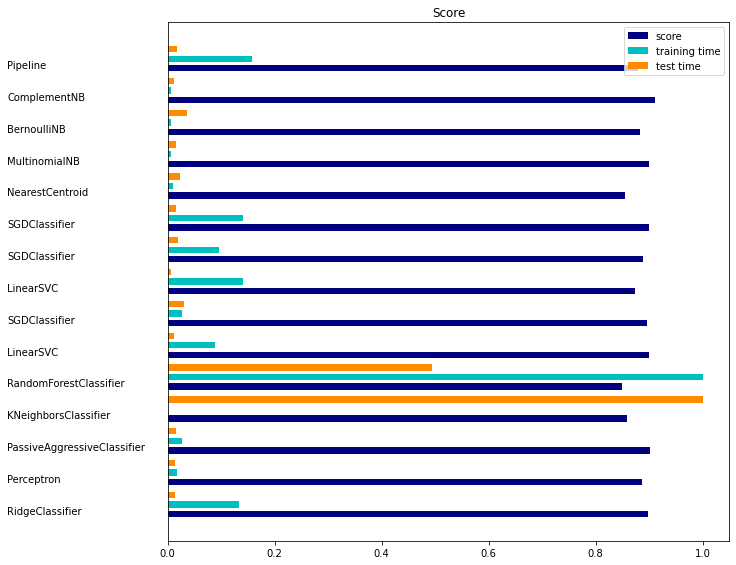

In [ ]:
import matplotlib.pyplot as plt

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

In [ ]:
import pandas as pd
# https://catalog.data.gov/dataset/consumer-complaint-database
df = pd.read_csv('/content/drive/MyDrive/Datasets/complaints.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2022-05-14,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TN,37115.0,NaN,Consent not provided,Web,2022-05-14,Closed with non-monetary relief,Yes,NaN,5561246
1,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"EQUIFAX, INC.",TX,77493.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5589545
2,2022-03-25,Checking or savings account,Other banking product or service,Managing an account,Funds not handled or disbursed as instructed,This is a forgery case. I made/wrote a check t...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,91343.0,NaN,Consent provided,Web,2022-03-25,Closed with explanation,Yes,NaN,5364709
3,2022-05-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Mercedes Benz Financial Services,OH,43123.0,NaN,NaN,Web,2022-05-23,In progress,Yes,NaN,5592245
4,2022-05-14,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"Bread Financial Holdings, Inc.",FL,32908.0,NaN,NaN,Web,2022-05-14,Closed with explanation,Yes,NaN,5563092


In [ ]:
df.shape


(2690958, 18)

In [ ]:
N = 2670000
df = df.iloc[:-N , :]
df.shape

(20958, 18)

In [ ]:
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6110 entries, 2 to 20957
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 6110 non-null   object
 1   Product                       6110 non-null   object
 2   Sub-product                   6110 non-null   object
 3   Issue                         6110 non-null   object
 4   Sub-issue                     5501 non-null   object
 5   Consumer complaint narrative  6110 non-null   object
 6   Company public response       4283 non-null   object
 7   Company                       6110 non-null   object
 8   State                         6086 non-null   object
 9   ZIP code                      6083 non-null   object
 10  Tags                          809 non-null    object
 11  Consumer consent provided?    6110 non-null   object
 12  Submitted via                 6110 non-null   object
 13  Date sent to comp

In [ ]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [ ]:

df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
2,Checking or savings account,This is a forgery case. I made/wrote a check t...,0
10,"Credit reporting, credit repair services, or o...","I have mailed, faxed, uploaded, and called all...",1
12,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX and Your agency Violated ...,1
17,"Credit reporting, credit repair services, or o...",THere are accounts under my name that is a res...,1
18,"Credit reporting, credit repair services, or o...",I am very concerned about the items that are b...,1


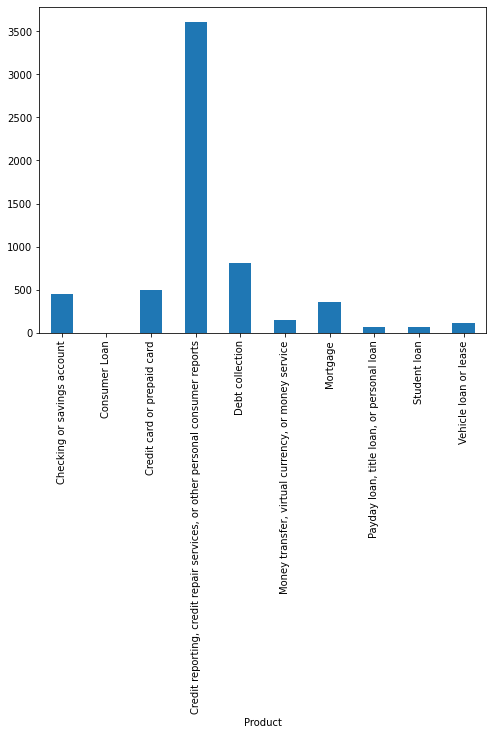

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(6110, 15088)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Checking or savings account':
  . Most correlated unigrams:
       . branch
       . bank
  . Most correlated bigrams:
       . debit card
       . checking account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Consumer Loan':
  . Most correlated unigrams:
       . holiday
       . investors
  . Most correlated bigrams:
       . yesterday xxxx
       . finance xxxx


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . american express
       . credit card


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
       . reporting
       . bank
  . Most correlated bigrams:
       . credit report
       . 1681 section


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Debt collection':
  . Most correlated unigrams:
       . collection
       . debt
  . Most correlated bigrams:
       . consumer reseller
       . collect debt


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
       . paypal
       . coinbase
  . Most correlated bigrams:
       . cash app
       . paypal account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Mortgage':
  . Most correlated unigrams:
       . escrow
       . mortgage
  . Most correlated bigrams:
       . loan modification
       . escrow account


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Payday loan, title loan, or personal loan':
  . Most correlated unigrams:
       . affirm
       . payday
  . Most correlated bigrams:
       . payday loan
       . wasnt aware


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Student loan':
  . Most correlated unigrams:
       . pslf
       . fedloan
  . Most correlated bigrams:
       . public service
       . sallie mae
# 'Vehicle loan or lease':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . purchased vehicle
       . used car


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

In [ ]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [ ]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


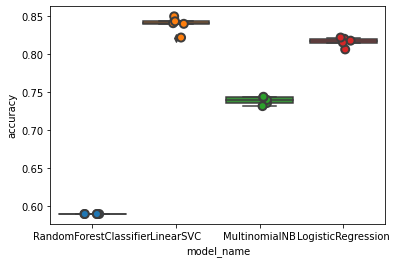

<Figure size 432x864 with 0 Axes>

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.figure(figsize=(6, 12))
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.838789
LogisticRegression        0.816039
MultinomialNB             0.738789
RandomForestClassifier    0.590016
Name: accuracy, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

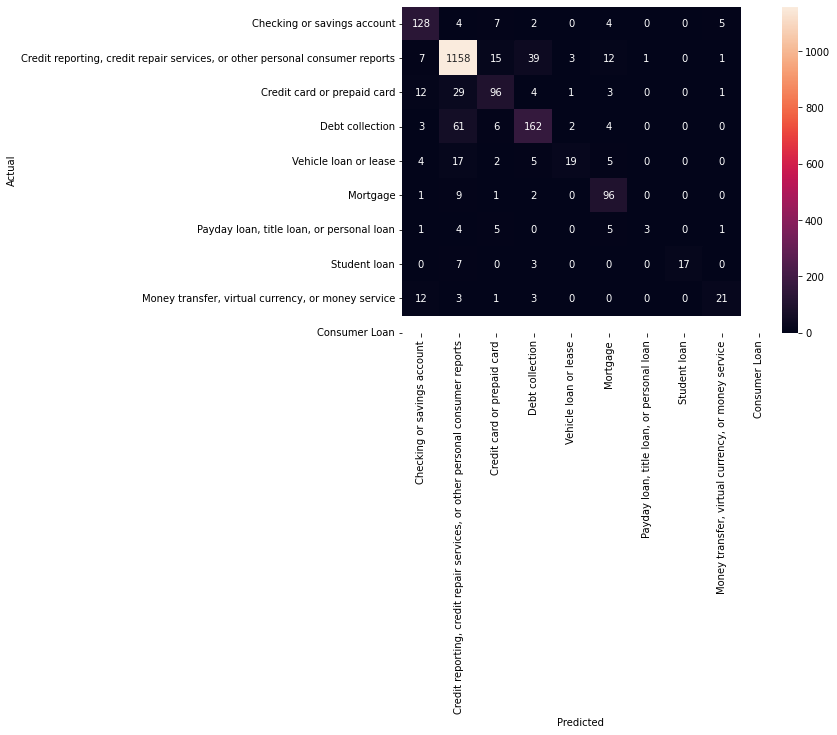

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 7 examples.


,Product,Consumer_complaint_narrative
9193,"Credit reporting, credit repair services, or o...",Wells Fargo {$350.00}
5939,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I was reported for suspected fra...
1571,"Credit reporting, credit repair services, or o...",I purchased my dog on XX/XX/XXXX from XXXX Ban...
9682,"Credit reporting, credit repair services, or o...",Ive contacted money lions fraud department via...
12551,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX I have not been able to o...
8766,"Credit reporting, credit repair services, or o...",I dont know the amount but I think its from ch...
16105,"Credit reporting, credit repair services, or o...",I used to live on XXXX XXXX XXXX XXXX and some...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 12 examples.


,Product,Consumer_complaint_narrative
4142,Credit card or prepaid card,I WAS PROVIDED WITH A XXXX GIFT CARD FOR {$10...
546,Credit card or prepaid card,Been getting these texts almost daily regardin...
6522,Credit card or prepaid card,"Hello, I have been a JP Morgan Chase Bank card..."
5758,Credit card or prepaid card,I was charged twice for the amount of XXXX whi...
13395,Credit card or prepaid card,PARAGRAPH 1 : I have been a Citi XXXX card hol...
9440,Credit card or prepaid card,I've recently noticed through an email that I ...
15260,Credit card or prepaid card,"XX/XX/XXXX, purchase made for airline tickets ..."
4853,Credit card or prepaid card,My card was stolen they provided me provisiona...
20488,Credit card or prepaid card,"I have had American Express, for twenty years,..."
11923,Credit card or prepaid card,I have a issue with a investigation regarding ...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 12 examples.


,Product,Consumer_complaint_narrative
628,"Money transfer, virtual currency, or money ser...",I input {$10000.00} to qualify for a crypto pr...
14367,"Money transfer, virtual currency, or money ser...",XX/XX/2022 I went to XXXX and did get release...
7411,"Money transfer, virtual currency, or money ser...",I have account with Gemini is a crypto exchang...
11081,"Money transfer, virtual currency, or money ser...",Citibank has issued me a fraudulent cashier 's...
11511,"Money transfer, virtual currency, or money ser...",I opened up a case with the the Consumer Finan...
10958,"Money transfer, virtual currency, or money ser...",I deposited a paycheck on XX/XX/2022 with the ...
12589,"Money transfer, virtual currency, or money ser...",I had my ssn check deposited and refunded disp...
5955,"Money transfer, virtual currency, or money ser...","On XX/XX/XXXX, I was contacted by a man named ..."
1185,"Money transfer, virtual currency, or money ser...",Attn : I had invested thousands of dollars in ...
15202,"Money transfer, virtual currency, or money ser...",I sent {$1100.00} to my parents in XXXX since ...


IndexError: ignored

In [ ]:
model.fit(features, labels)
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'Checking or savings account':
  . Top unigrams:
       . bank
       . checking
  . Top bigrams:
       . checking account
       . debit card
# 'Consumer Loan':
  . Top unigrams:
       . investors
       . holiday
  . Top bigrams:
       . finance xxxx
       . xxxx finance
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . citi
  . Top bigrams:
       . american express
       . credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . experian
       . transunion
  . Top bigrams:
       . xxxx xxxx
       . bad debt
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . called xxxx
       . trade commisions
# 'Money transfer, virtual currency, or money service':
  . Top unigrams:
       . paypal
       . crypto
  . Top bigrams:
       . cash app
       . wire transfer
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . escrow
  . Top bigrams:
 

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting, credit repair services, or other personal consumer reports'

"I can't get the money out of the country."
  - Predicted as: 'Checking or savings account'

"I have no money to pay my tuition"
  - Predicted as: 'Checking or savings account'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [ ]:
print(df['Product'].unique())

['Checking or savings account'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Debt collection' 'Vehicle loan or lease'
 'Mortgage' 'Payday loan, title loan, or personal loan' 'Student loan'
 'Money transfer, virtual currency, or money service' 'Consumer Loan']


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       150
           1       0.90      0.94      0.92      1236
           2       0.72      0.66      0.69       146
           3       0.74      0.68      0.71       238
           4       0.76      0.37      0.49        52
           5       0.74      0.88      0.81       109
           6       0.75      0.16      0.26        19
           7       1.00      0.63      0.77        27
           8       0.72      0.53      0.61        40

    accuracy                           0.84      2017
   macro avg       0.79      0.63      0.67      2017
weighted avg       0.84      0.84      0.84      2017

